In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from terratorch.registry import BACKBONE_REGISTRY, DECODER_REGISTRY
from terratorch.models import EncoderDecoderFactory
import torch
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import cv2
import torch

from eosfm.datamodules import CaFFeDataModule

import os
import glob
from pathlib import Path

/share/home/adorni/bench/ensemble/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.6.0 available.


In [10]:
backbone = BACKBONE_REGISTRY.build(
    "timm_convnextv2_atto",
    pretrained=False,
    in_chans=3
)

decoder = DECODER_REGISTRY.build(
    "UperNetDecoder",
    channels=128,
    embed_dim=[40, 80, 160, 320],
)

model = EncoderDecoderFactory().build_model(
    task="segmentation",
    backbone=backbone,
    decoder=decoder,
    num_classes=2,
    head_channel_list=[128]
)

state_dict = torch.load("experiments/etci2021/version_20/checkpoints/epoch=99-step=4300.ckpt")["state_dict"]
for key in list(state_dict.keys()):
    if key.startswith("model."):
        new_key = key.removeprefix("model.")
        state_dict[new_key] = state_dict.pop(key)

model.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'experiments/etci2021/version_20/checkpoints/epoch=99-step=4300.ckpt'

In [3]:
from eosfm.encoder import EosFM

In [44]:
eosfm = EosFM("../experiments", "cuda")
print(f"Model has {sum(p.numel() for p in eosfm.parameters() if p.requires_grad):,} trainable parameters.")

Loading encoders: 100%|██████████| 14/14 [00:02<00:00,  5.30it/s, encoder=etci2021]     

Loaded encoders: ['caffe', 'sen12ms-s1', 'sen12ms-s2', 'deepglobe-lcc', 'bigearthnet-S1', 'eurosat', 'bigearthnet', 'firerisk', 'sen12ms-rgb', 'imagenet', 'minifrance', 'etci2021']
Model has 40,654,560 trainable parameters.


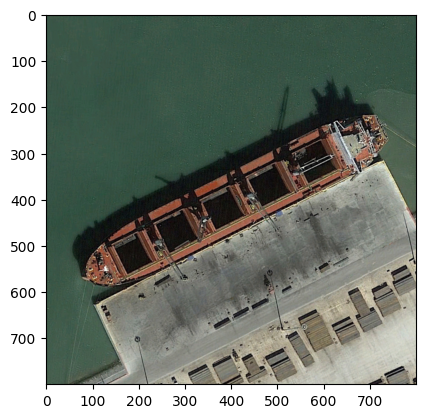

In [45]:
image = cv2.imread("../data/dior/Images/trainval/00032.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [12]:
from eosfm.band_adaptation import ADAPTATIONS_REGISTRY

In [13]:
ADAPTATIONS_REGISTRY

{(3, 12): [eosfm.band_adaptation.S2toRGB],
 (3, 2): [eosfm.band_adaptation.SARtoRGB],
 (12, 14): [eosfm.band_adaptation.S12ToS2],
 (2, 14): [eosfm.band_adaptation.S12ToSAR],
 (3, 14): [eosfm.band_adaptation.S12ToRGB]}

In [46]:
x = (torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float() / 255.0).to("cuda")
x.shape

torch.Size([1, 3, 800, 800])

In [54]:
features = eosfm(x)

<string>:13: UserWarning: Encoder sen12ms-s2 requires 13 bands but input has 3, and no adaptation strategy is defined. skipping encoder.
<string>:13: UserWarning: Encoder bigearthnet requires 14 bands but input has 3, and no adaptation strategy is defined. skipping encoder.


In [72]:
eosfm.encoders[0].out_channels

[40, 80, 160, 320]

In [52]:
for feat in features:
    print(feat.shape)

torch.Size([1, 400, 200, 200])
torch.Size([1, 800, 100, 100])
torch.Size([1, 1600, 50, 50])
torch.Size([1, 3200, 25, 25])


In [ ]:
state_dict = torch.load("../experiments/etci2021/version_20/checkpoints/epoch=99-step=4300.ckpt", map_location="cpu")["state_dict"]
state_dict = {k:v for k,v in state_dict.items() if k.startswith("model.encoder.")}
state_dict = {k.removeprefix("model.encoder."): v for k, v in state_dict.items()}

In [70]:
torch.load("../experiments/etci2021/version_20/checkpoints/epoch=99-step=4300.ckpt", map_location="cpu")["hyper_parameters"]

{'_class_path': 'terratorch.tasks.SemanticSegmentationTask',
 'model_args': {'backbone': 'timm_convnextv2_atto',
  'backbone_pretrained': True,
  'backbone_in_chans': 3,
  'decoder': 'UperNetDecoder',
  'decoder_channels': 128,
  'head_channel_list': [128],
  'head_dropout': 0.1,
  'num_classes': 2},
 'model_factory': 'EncoderDecoderFactory',
 'model': None,
 'loss': 'dice',
 'aux_heads': None,
 'aux_loss': None,
 'class_weights': None,
 'ignore_index': -1,
 'lr': 0.001,
 'optimizer': None,
 'optimizer_hparams': None,
 'scheduler': None,
 'scheduler_hparams': None,
 'freeze_backbone': False,
 'freeze_decoder': False,
 'freeze_head': False,
 'plot_on_val': False,
 'class_names': None,
 'tiled_inference_parameters': None,
 'test_dataloaders_names': None,
 'lr_overrides': None,
 'output_most_probable': True,
 '_instantiator': 'lightning.pytorch.cli.instantiate_module'}

In [57]:
img = rasterio.open("../data/eurosat/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Industrial/Industrial_5.tif").read()

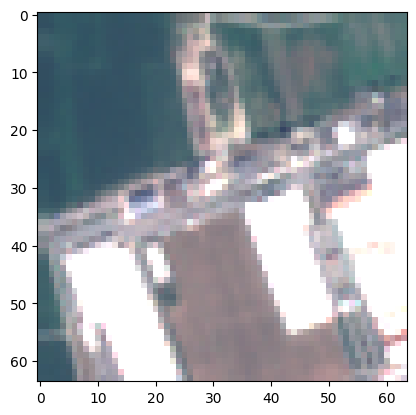

In [67]:
plt.imshow(np.transpose(img[[3,2,1], :, :], (1, 2, 0))/2000)

In [47]:
config = torch.load("../experiments/etci2021/version_20/checkpoints/epoch=99-step=4300.ckpt", map_location="cpu")["hyper_parameters"]
config_model = config["model_args"]
config_backbone = {k:v for k, v in config_model.items() if k.startswith("backbone")}
config_backbone

{'backbone': 'timm_convnextv2_atto',
 'backbone_pretrained': True,
 'backbone_in_chans': 3}

In [53]:
model = BACKBONE_REGISTRY.build(config_backbone["backbone"], in_chans=config_backbone["backbone_in_chans"], pretrained=False)

In [64]:
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>